In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pypfopt
import yfinance as yf

from portfolio_tools import load_data_for_portfolio, calc_frontier, calc_weights, weights_to_df

In [3]:
tickers = ["MSFT", "AMZN", "NAT", "BAC",  "DIS", "KO", "MCD", "COST", "SBUX"]

In [4]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%%**********************]  9 of 9 completed


Ticker,AMZN,BAC,COST,DIS,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,
2024-03-18,174.479995728,36.009998322,731.539978027,113.849998474,60.130001068,278.579986572,417.320007324,3.910000086,91.010002136
2024-03-19,175.899993896,36.029998779,732.169982910,114.510002136,60.229999542,282.869995117,421.410003662,3.880000114,91.589996338
2024-03-20,178.149993896,36.750000000,740.719970703,116.459999084,60.750000000,284.450012207,425.230010986,3.849999905,92.599998474
2024-03-21,178.149993896,37.509998322,742.559997559,116.699996948,60.470001221,283.529998779,429.369995117,4.000000000,91.660003662
2024-03-22,178.869995117,37.049999237,734.799987793,115.870002747,60.490001678,282.630004883,428.739990234,3.930000067,90.709999084


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29    24.763738632
1993-02-01    24.939859390
1993-02-02    24.992685318
1993-02-03    25.256885529
1993-02-04    25.362579346
Name: Adj Close, dtype: float64

In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3192492130304,
 'AMZN': 1857994096640,
 'NAT': 820568320,
 'BAC': 295978008576,
 'DIS': 214062874624,
 'KO': 260783898624,
 'MCD': 204723322880,
 'COST': 325886738432,
 'SBUX': 102703677440}

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.722610472941319

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
AMZN    0.180668656
BAC     0.102938632
COST    0.081895540
DIS     0.095311456
KO      0.063775868
MCD     0.067538051
MSFT    0.150310353
NAT     0.053152838
SBUX    0.082430261
dtype: float64

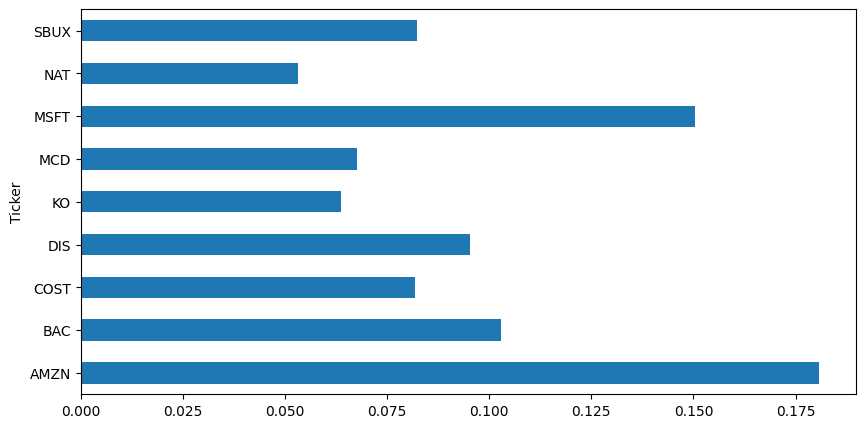

In [9]:
market_prior.plot.barh(figsize=(10,5));

In [10]:
# You don't have to provide views on all the assets
viewdict = {
    #"AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [12]:
confidences = [
#    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

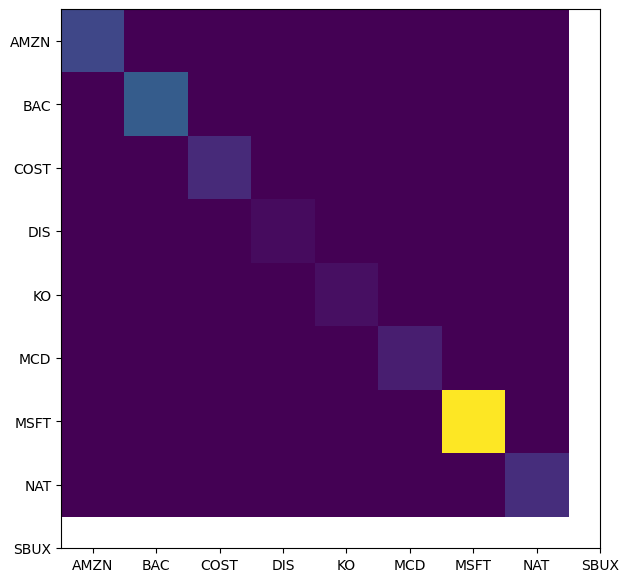

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [22]:
intervals = [
#    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [23]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


In [21]:

# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

AssertionError: omega must have dimensions KxK

In [18]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
AMZN    0.158139143
BAC     0.116276860
COST    0.057500884
DIS     0.067194556
KO      0.005769997
MCD     0.100025499
MSFT    0.103852941
NAT     0.049147888
SBUX    0.068464358
dtype: float64

In [35]:

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.180493303,0.141534265,0.10
BAC,0.103001203,0.114974904,0.30
COST,0.082001175,0.056443316,0.05
DIS,0.095364789,0.066357582,0.05
KO,0.063823457,0.005818535,-0.05
MCD,0.067586470,0.099884703,0.15
MSFT,0.150392304,0.103484395,0.10
NAT,0.053165971,0.048149046,0.50
SBUX,0.082481664,0.066633829,0.10


In [39]:
S_bl = bl.bl_cov()


In [36]:
from pypfopt import EfficientFrontier, objective_functions

In [40]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights
     

D:\Soft\Anaconda\envs\t\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.23218),
             ('BAC', 0.17761),
             ('COST', 0.06305),
             ('DIS', 0.07562),
             ('KO', 0.0),
             ('MCD', 0.15887),
             ('MSFT', 0.16269),
             ('NAT', 0.04785),
             ('SBUX', 0.08213)])

In [41]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc
     

Leftover: $700.55


D:\Soft\Anaconda\envs\t\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'BAC': 109,
 'COST': 2,
 'DIS': 16,
 'KO': 10,
 'MCD': 12,
 'MSFT': 8,
 'NAT': 600,
 'SBUX': 22}

### Crypto

In [10]:
pair = "USDT"
index_assets = pd.read_csv('index_assets.csv')['asset'].tolist()
assets = index_assets
markets = [m + '-' + pair for m in assets]
df_all =  load_data_for_portfolio(markets, '4h')   

AAVE-USDT
ADA-USDT
ALGO-USDT
APT-USDT
AVAX-USDT
AXS-USDT
BNB-USDT
BONK-USDT
CAKE-USDT
CYBER-USDT
DOGE-USDT
DOT-USDT
EOS-USDT
ETC-USDT
ETH-USDT
ETHFI-USDT
FIRE-USDT
FTT-USDT
FTM-USDT
GALA-USDT
INJ-USDT
JUP-USDT
LINK-USDT
LTC-USDT
LUNA-USDT
MATIC-USDT
NEON-USDT
NEAR-USDT
NGL-USDT
ONDO-USDT
ONDO-USDT Нет данных
PEPE-USDT
PPT-USDT
PYTH-USDT
RUNE-USDT
SEI-USDT
SOL-USDT
SUI-USDT
THETA-USDT
TOKEN-USDT
TOKEN-USDT Нет данных
TRX-USDT
UNI-USDT
WAVES-USDT
WLD-USDT
XRP-USDT
ZIL-USDT
